Louis de Vitry
Maximilien Barbé
Cynthia El Hayek

In [1]:
# BASIC PACKAGES
import numpy as np
import networkx as nx
import pandas as pd

import random

# DATA TOOLS
from Tools.data.data_helpers import kaggle_submission, retrieve_data
from Tools.data.graph_helpers import construct_graph, construct_digraph

# FEATURE ENGINEERING
from Tools.features.node_based import node_degrees
from Tools.features.nlp_based import doc2vec_similarities, clean_doc, compute_cosine, tfidf, train_w2v
from Tools.features.information_based import given_feature_engineering
from Tools.features.flow_based import flow_features
from Tools.features.neighborhood_based import neighborhood_features
from Tools.features.path_based import path_features

# PRE-PROCESSING
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# FEATURE SELECTION
from xgboost import plot_importance
from Tools.features.feature_selection import log_transform

# MODELS SELECTION
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from Tools.models.models import cross_validation_models
from Tools.models.time import timer

# SUPERVISED MODELS
## ML models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Deep Learning
from keras.wrappers.scikit_learn import KerasClassifier
from Tools.models.models import create_baseline


# ATTEMPT TO AUTO-ML (UNSUCCESSFUL)
from auto_ml import Predictor
from auto_ml.utils_models import load_ml_model

## PLOTS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

Using TensorFlow backend.


# Basics
## Reading data

In [2]:
training_set, testing_set, node_info, IDs = retrieve_data()

In [3]:
print('Size of training set: ' + str(len(training_set)))
print('Size of testing set: ' + str(len(testing_set)))

Size of training set: 615512
Size of testing set: 32648


## Random Baseline

In [4]:
# Predictions
random_predictions = np.random.choice([0, 1], size=len(testing_set))
# Kaggle output
kaggle_submission(random_predictions, 'random_baseline')

## Train test split

For each training example we need to compute features in this baseline we will train the model on only 5% of the training set.

In [5]:
# Randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]

# Feature engineering

## Baseline

The baseline is made of the following features
- Number of overlapping words in title?
- Temporal distance between the papers
- Number of common authors

To beat the random and the given baseline (with f1 score of 0.66), we will create additional features

0. Keep the baseline features in our analysis
1. Information based feature engineering
2. Basic features of [Link prediction](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_prediction.html)
3. ....

## Information based feature engineering

### Data

The columns of the data frame below are: 
1. Paper unique ID (integer)
2. Publication year (integer)
3. Paper title (string)
4. Authors (strings separated by ,)
5. Name of journal (optional) (string)
6. Abstract (string) - lowercased, free of punctuation except intra-word dashes

### Word embeddings on the abstract

We tried several approach to make sense of the abstract of the publications.

1. <b>Cosine similarity</b> using tf-idf features

```
vectorizer, features_tfidf = tfidf(node_info)
cosines_train = compute_cosine(training_set_reduced, features_tfidf, IDs)
cosines_test = compute_cosine(testing_set, features_tfidf, IDs)
```

2. <b>Word2Vec:</b> In develoment. Cosine similarity of the titles.

3. <b>Doc2Vec:</b> We train a Doc2vec (using `train_w2v(node_info, 'abstracts2vec')`), which is based on [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053v2.pdf)

In [6]:
print('Doc2Vec training on paper absract...')
start_time = timer(None)
train_w2v(node_info, 'title2vec', train_on = 'abstract', cut_words = 2, train = False)
timer(start_time)

Doc2Vec training on paper absract...
Time taken: 0 hours 0 minutes and 0.0 seconds.


In [7]:
print('Doc2Vec similarities computing...')
start_time = timer(None)
cosines_sim_abs_train = doc2vec_similarities(training_set_reduced, node_info, IDs, name = 'd2v_10_3')
cosines_sim_abs_test = doc2vec_similarities(testing_set, node_info, IDs, name = 'd2v_10_3')
timer(start_time)

Doc2Vec similarities computing...
Time taken: 0 hours 11 minutes and 3.99 seconds.


In [8]:
vectorizer, features_tfidf = tfidf(node_info)

print('Generating basic features from node informations...')
start_time = timer(None)
classic_feature_train = given_feature_engineering(training_set_reduced, node_info, IDs, features_tfidf)
classic_feature_test = given_feature_engineering(testing_set, node_info, IDs, features_tfidf)
timer(start_time)

Generating basic features from node informations...
Time taken: 0 hours 8 minutes and 25.75 seconds.


## Graph based features

In [9]:
print('Constructing undirected + directed graphs...')
start_time = timer(None)
g = construct_graph(training_set, node_info)
g_di = construct_digraph(training_set, node_info)
timer(start_time)

print('Generating node-based features...')
start_time = timer(None)
degrees_train = node_degrees(g_di, training_set_reduced)
degrees_test = node_degrees(g_di, testing_set)
timer(start_time)

print('Generating path based features for undirected graph...')
start_time = timer(None)
path_train = path_features(g, training_set_reduced, IDs, name = 'shortest_path')
path_test = path_features(g, testing_set, IDs, name = 'shortest_path')
timer(start_time)

print('Generating path based features for directed graph...')
start_time = timer(None)
path_di_train = path_features(g_di, training_set_reduced, IDs, name = 'shortest_path_di')
path_di_test = path_features(g_di, testing_set, IDs, name = 'shortest_path_di')
timer(start_time)

print('Generating neighborhood based features...')
start_time = timer(None)
neighborhood_train = neighborhood_features(g, training_set_reduced)
neighborhood_test = neighborhood_features(g, testing_set)
timer(start_time)

Constructing undirected + directed graphs...
Time taken: 0 hours 0 minutes and 2.32 seconds.
Generating node-based features...
Time taken: 0 hours 0 minutes and 0.54 seconds.
Generating path based features for undirected graph...
Time taken: 0 hours 0 minutes and 14.59 seconds.
Generating path based features for directed graph...
Time taken: 0 hours 1 minutes and 34.19 seconds.
Generating neighborhood based features...
Time taken: 0 hours 0 minutes and 41.71 seconds.


# EDA

<Figure size 720x720 with 0 Axes>

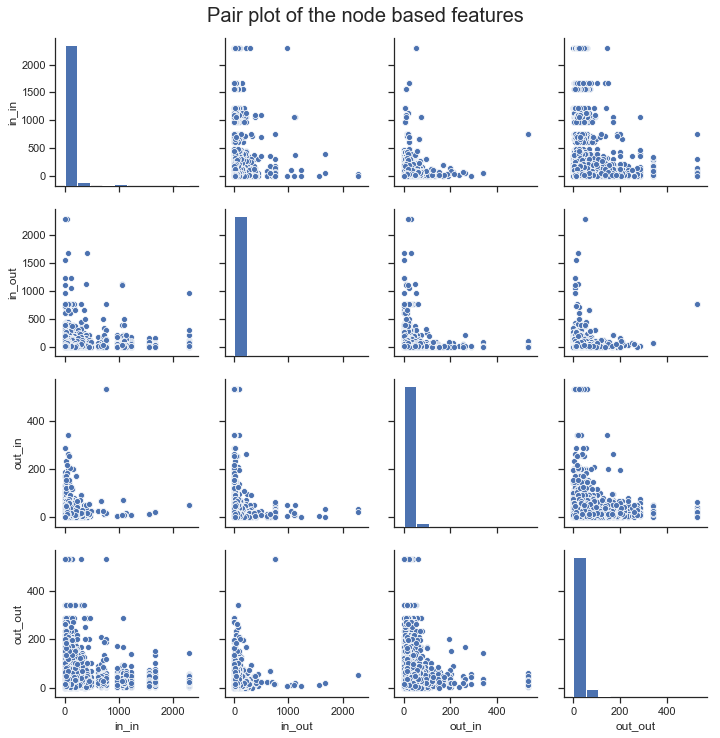

In [10]:
plt.figure(figsize = (10, 10))
g = sns.pairplot(degrees_train)
g.fig.suptitle("Pair plot of the node based features", fontsize = 20, y=1.02)

plt.show()

### Create train / test sets with response

In [11]:
# Concatenation
training_features = pd.concat((classic_feature_train, cosines_sim_abs_train, degrees_train, path_train, path_di_train, neighborhood_train), axis = 1)
testing_features = pd.concat((classic_feature_test, cosines_sim_abs_test, degrees_test, path_test, path_di_test, neighborhood_test), axis = 1)
columns = training_features.columns.values

# Preprocess labels
labels = [int(element[2]) for element in training_set_reduced]
training_features['label'] = np.array(list(labels))

In [12]:
training_features.head()

,overlap_title,temp_diff,comm_auth,cosimi,cosine_similarity,in_in,in_out,out_in,out_out,shortest_path,shortest_path_di,ressource_allocation,jaccard,adamic_adar,preferential,common_neighbors,label
0,0.0,-3.0,0.0,0.000000,0.384532,2,77,24,51,-3,1,0.000000,0.000000,0.000000,3328.0,0.0,0
1,0.0,3.0,0.0,0.060397,0.784398,144,52,10,16,-1,-1,0.405001,0.072464,4.064915,10472.0,15.0,1
2,0.0,0.0,1.0,0.000000,0.666527,2,2,2,2,-6,1,0.000000,0.000000,0.000000,16.0,0.0,0
3,0.0,0.0,2.0,0.000000,0.887743,107,57,60,27,-1,-1,0.369866,0.096916,5.242921,13860.0,22.0,1
4,0.0,2.0,0.0,0.000000,0.662728,1,5,10,7,-3,-12,0.000000,0.000000,0.000000,132.0,0.0,0


# Feature transformation

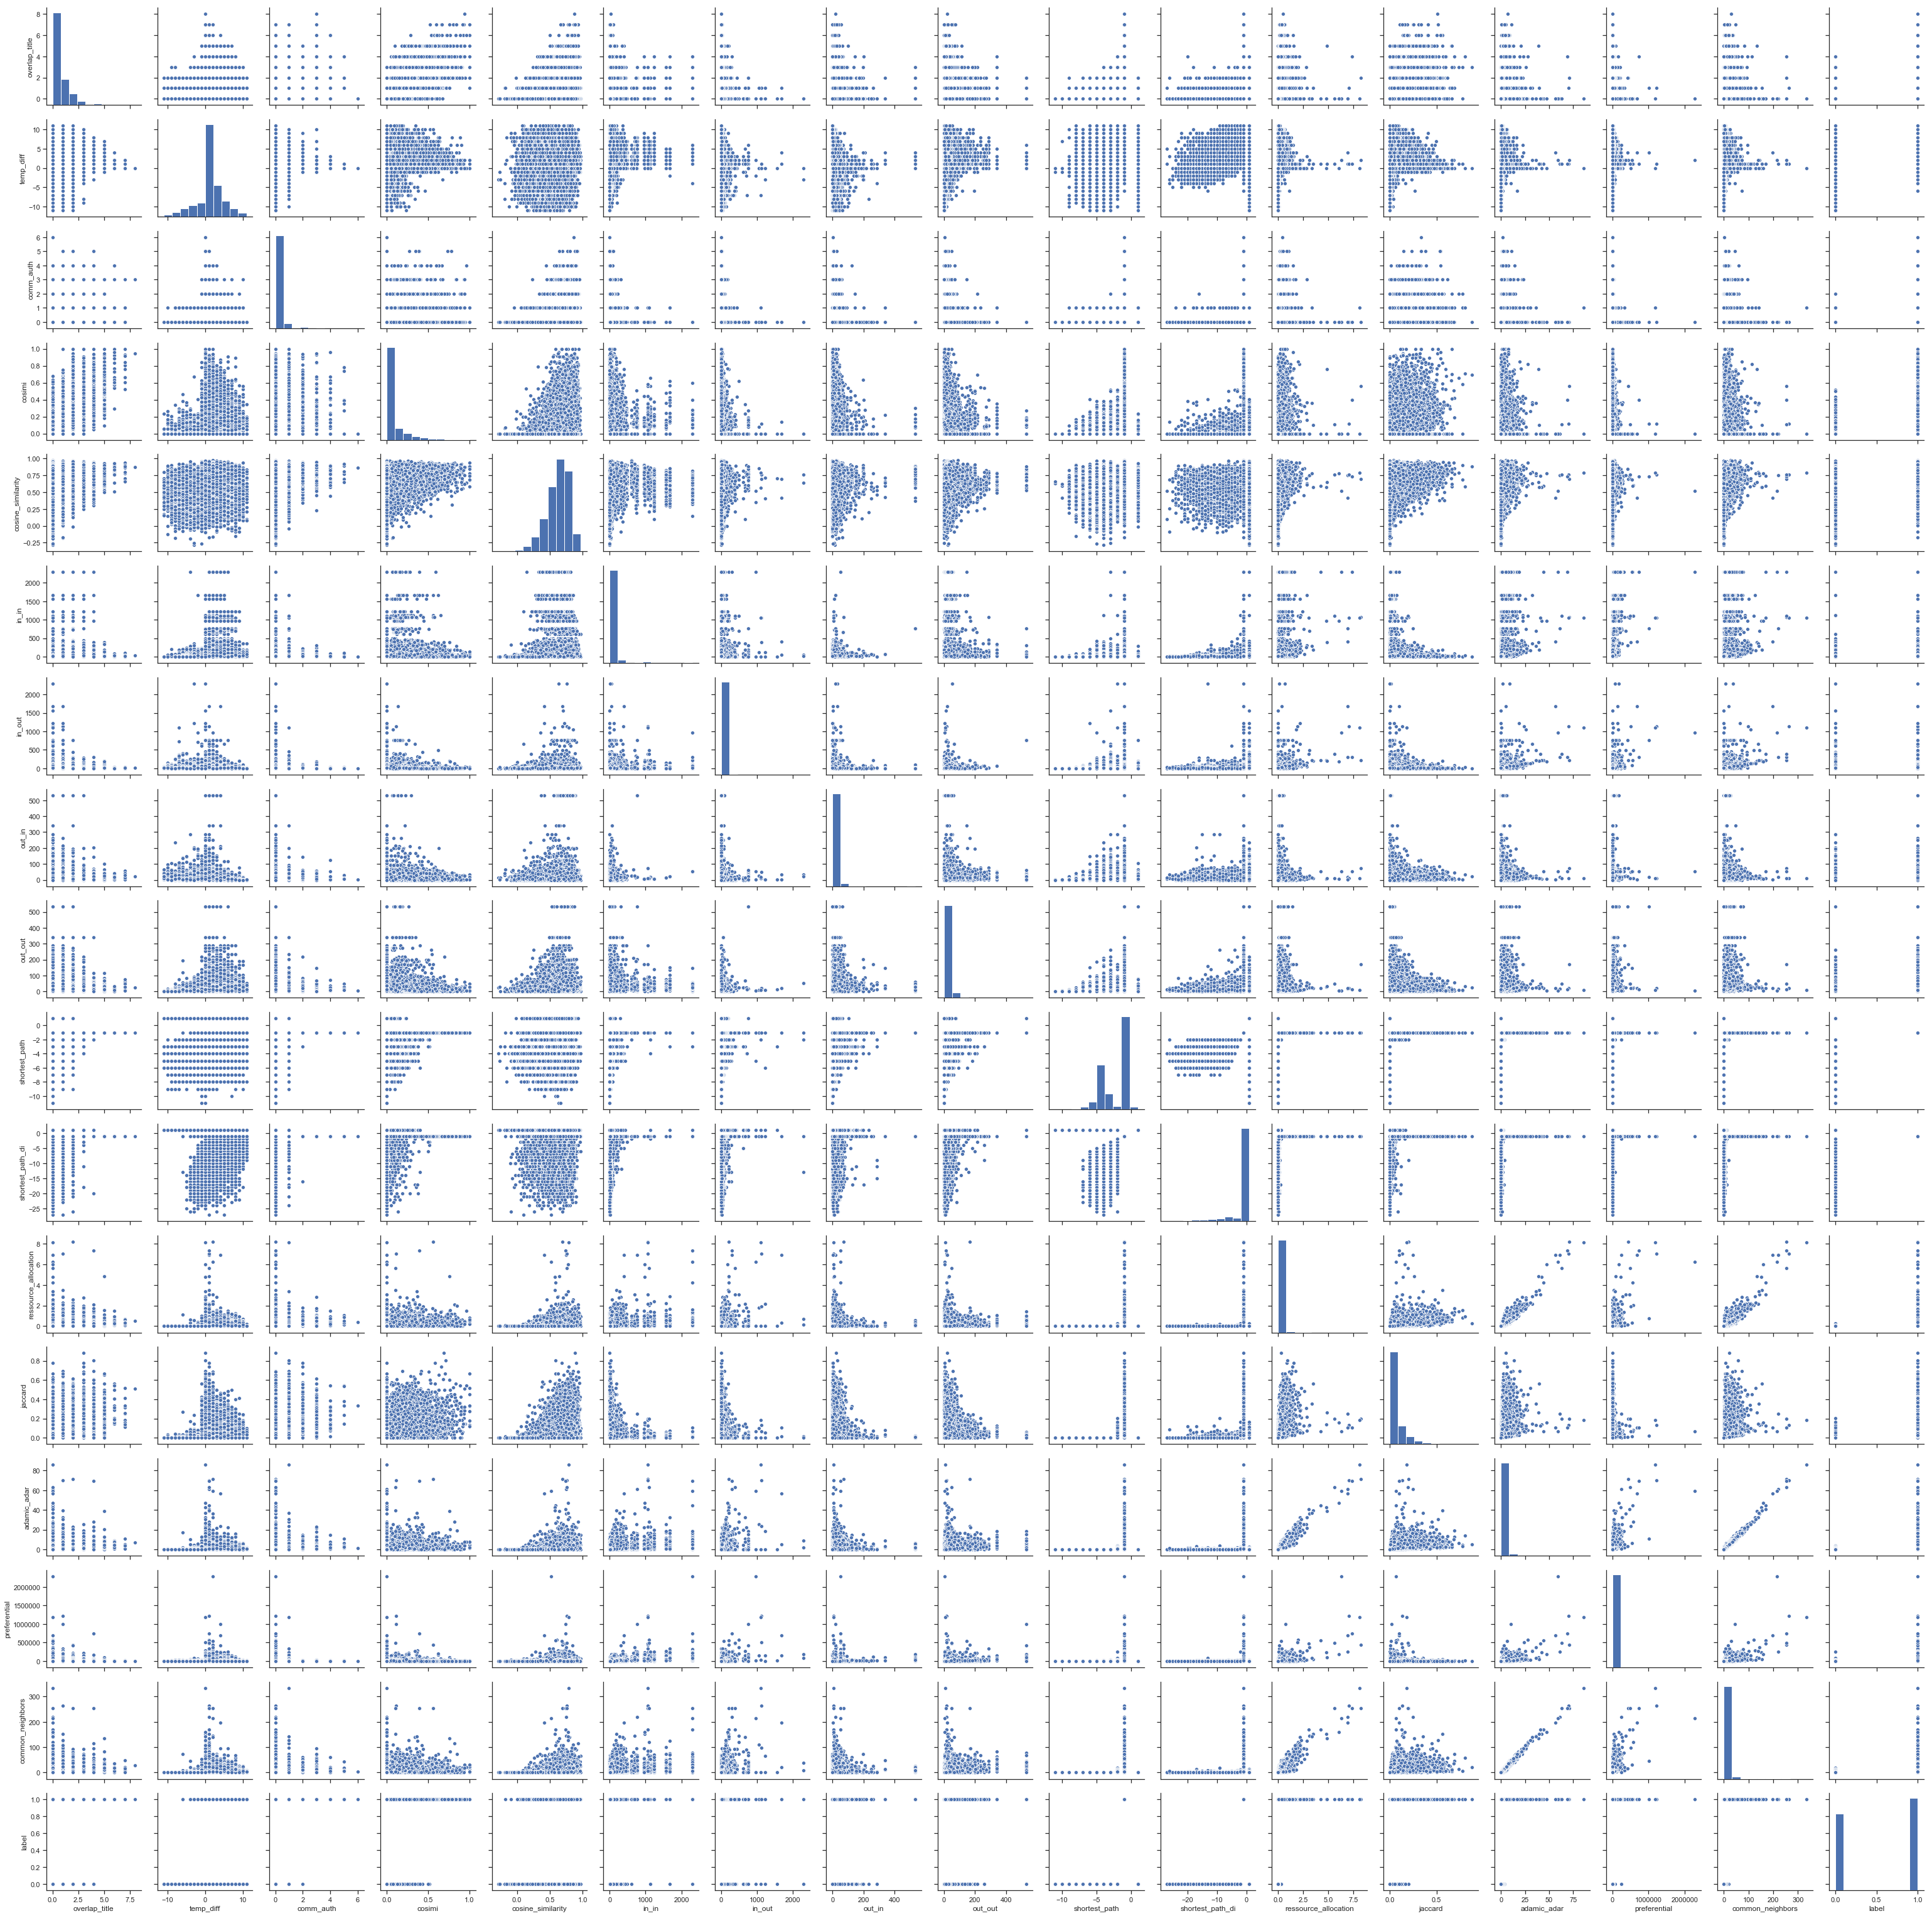

In [13]:
# Pair plot
g = sns.pairplot(training_features)

In [14]:
def log_transform(training_features, list_names = ['in_in', 'out_out', 'in_out', 'out_in'], inplace = True):
    for name in list_names:
        if inplace:
            training_features[[name]] = np.log(training_features[[name]] + 1)
        else:
            training_features[['log_' + name]] = np.log(training_features[[name]] + 1)
    return(training_features)

In [15]:
# Log transforms
training_features = log_transform(training_features, list_names = ['in_in', 'out_out', 'in_out', 'out_in'], inplace = True)
testing_features = log_transform(testing_features, list_names = ['in_in', 'out_out', 'in_out', 'out_in'], inplace = True)

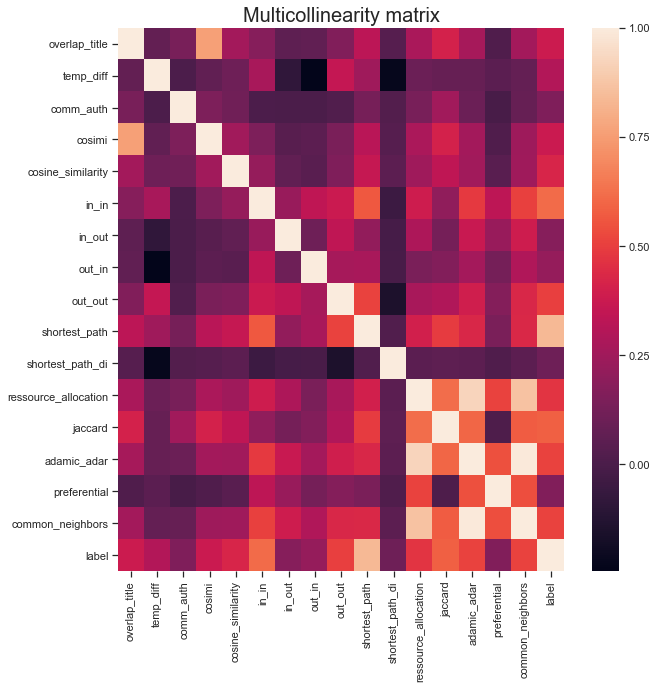

In [16]:
# Multicollinearity matrix
plt.figure(figsize = (10, 10))
sns.heatmap(training_features.corr())
plt.title('Multicollinearity matrix', fontsize = 20)
plt.show()

### Analyzing shortest paths

In [17]:
training_features[training_features['shortest_path']!=2]['label'].sum()

16814

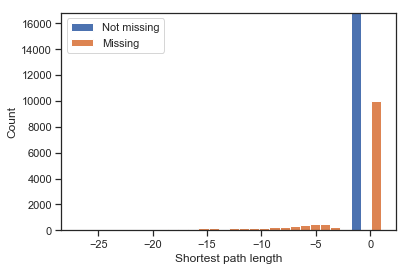

In [18]:
# Shortest paths
plt.hist([training_features[training_features['label']==1]['shortest_path_di'], training_features[training_features['label']==0]['shortest_path_di']], stacked=True, bins=30, label=['Not missing','Missing'])
plt.xlabel('Shortest path length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [19]:
training_features['shortest_path'] = np.where(training_features['shortest_path'] == 2, 1, 0)
testing_features['shortest_path'] = np.where(testing_features['shortest_path'] == 2, 1, 0)

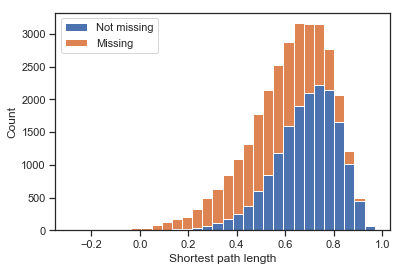

In [20]:
# Shortest paths
plt.hist([training_features[training_features['label']==1]['cosine_similarity'], training_features[training_features['label']==0]['cosine_similarity']], stacked=True, bins=30, label=['Not missing','Missing'])
plt.xlabel('Shortest path length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [21]:
training_features['shortest_path_di'] = np.where(training_features['shortest_path_di'] == 2, 1, 0)
testing_features['shortest_path_di'] = np.where(testing_features['shortest_path_di'] == 2, 1, 0)

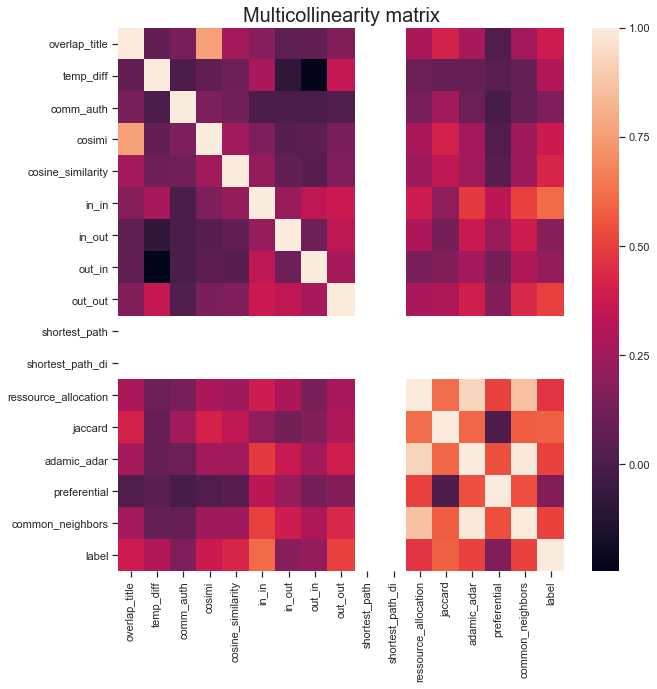

In [22]:
# Multicollinearity matrix
plt.figure(figsize = (10, 10))
sns.heatmap(training_features.corr())
plt.title('Multicollinearity matrix', fontsize = 20)
plt.show()

In [23]:
# SELECT FEATURES!!!!
features_final = training_features.columns.values

In [24]:
features_final

array(['overlap_title', 'temp_diff', 'comm_auth', 'cosimi',
       'cosine_similarity', 'in_in', 'in_out', 'out_in', 'out_out',
       'shortest_path', 'shortest_path_di', 'ressource_allocation',
       'jaccard', 'adamic_adar', 'preferential', 'common_neighbors',
       'label'], dtype=object)

# Feature selection

- Fifth baseline - All features
- Sixth baseline ['adamic_adar','common_neighbors','preferential','ressource_allocation','shortest_path','shortest_path_di']
- Seventh ['shortest_path']
- Sixth baseline ['shortest_path', 'ressource_allocation']
- Tenth baseline
features_to_select = columns
- Eleventh baseline - All but shortest dist di
- Twelveth baseline - All but shortest dist + shortest dist di

In [25]:
baseline = ['comm_auth', 'overlap_title', 'temp_diff']
nlp = ['cosine_similarity', 'cosimi']
neighborhood = ['preferential', 'jaccard', 'common_neighbors', 'ressource_allocation', 'adamic_adar']
path = ['shortest_path', 'shortest_path_di']
node = ['in_out', 'out_in', 'in_in', 'out_out']

In [26]:
features_to_select = baseline + nlp + neighborhood

In [27]:
# Prior feature selection
X_train = training_features[features_to_select]
y_train = training_features['label']
X_test = testing_features[features_to_select]

# Models

In [28]:
print('Class imbalance: ' + str(y_train.sum()/float(len(y_train))))

Class imbalance: 0.5463348063426047


In [29]:
from sklearn.preprocessing import MinMaxScaler
# Scale
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = features_to_select)
X_test = pd.DataFrame(scaler.transform(X_test), columns = features_to_select)

In [30]:
X_train.shape

(30776, 10)

In [31]:
#import sklearn import model_selection
# MACHINE LEARNING
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier(max_depth = 5)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier(max_depth = 5)))
models.append(('XGBoost', XGBClassifier(subsample = 0.8, gamma = 1, colsample_bytree = 1.0, min_child_weight = 1, max_depth = 4)))

In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def cross_validation_models(models, X_train, y_train, n_splits = 10):
    # Evaluate each model with 10-fold cross-validation
    results = []
    names = []
    scoring = 'f1'
    for name, model in models:
        kfold = StratifiedKFold(n_splits=n_splits, random_state=1)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

In [33]:
cross_validation_models(models, X_train, y_train)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR: 0.936746 (0.004244)
DT: 0.969466 (0.003549)
LDA: 0.892180 (0.005410)
KNN: 0.951307 (0.004951)
NB: 0.958130 (0.002090)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM: 0.927324 (0.003734)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.968790 (0.003670)
XGBoost: 0.970878 (0.003278)


In [34]:
def fit_predict(trained_models, X_train, y_train, X_test, to_csv = True, title = 'new_one'):
    # Fit
    for name, model in trained_models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        if to_csv: kaggle_submission(predictions, title + name)

In [35]:
fit_predict(models, X_train, y_train, X_test, title = 'base5_')

In [36]:
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score, f1_score

# DEFINE MODEL AND PERFORMANCE MEASURE
mdl = SVC(probability = True, random_state = 1)
auc = make_scorer(f1_score)

 
# RANDOM SEARCH FOR 20 COMBINATIONS OF PARAMETERS
rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
rand_search.fit(X_train, y_train) 
rand_search.cv_results_

KeyboardInterrupt: 

# Parameter tuning - Only Xgboost but logic is close for other classifiers

In [ ]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
print('\n All results:')
#print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [ ]:
# Fit
for name, model in models:
    model.fit(training_features, labels_array)
    predictions = model.predict(testing_features)
    kaggle_submission(predictions, 'xgboost_baseline_' + name)

In [ ]:
kaggle_submission(ml_predictor.predict(testing_features), 'auto_ml')

## Feature importance - Model based

### Xgboost

In [ ]:
plot_importance(models[7][1])

## Random forests

In [ ]:
feature_importances_rf = dict(zip(training_features.columns.values, models[6][1].feature_importances_))

# Deep Learning

In [ ]:
# PRE-PROCESSING
encoder = LabelEncoder()
encoder.fit(labels_array)
encoded_Y = encoder.transform(labels_array)

# MODEL TRAINING AND TESTING
estimator = KerasClassifier(build_fn=create_baseline, epochs=7, batch_size=5, verbose=1)
estimator.fit(training_features, encoded_Y)
predictions = estimator.predict(testing_features)
predictions = predictions.ravel()

# KAGGLE
kaggle_submission(predictions.ravel(), 'third_baseline_NNET')

# Sources

https://archive.siam.org/meetings/sdm06/workproceed/Link%20Analysis/12.pdf

https://networkx.github.io/documentation/stable/reference/algorithms/index.html

https://arxiv.org/pdf/1411.5118.pdf

https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf

https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity

https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/centrality/betweenness.html#edge_betweenness_centrality

https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5

https://stackoverflow.com/questions/46807010/what-are-doc2vec-training-iterations
https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5

https://stackoverflow.com/questions/45125798/how-to-use-taggeddocument-in-gensim

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/